In [142]:
import xgboost as xgb
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [143]:
google = yf.Ticker("AAPL")
df = google.history(period="2y", interval='1h').drop(columns=["Dividends", "Stock Splits"])
df2 = df.copy()
df2.reset_index(inplace=True)
df2.head()

,index,Open,High,Low,Close,Volume
0,2020-06-29 09:30:00-04:00,88.312500,89.379997,87.820000,89.302498,8955346
1,2020-06-29 10:30:00-04:00,89.307503,89.964996,89.199997,89.917450,4733992
2,2020-06-29 11:30:00-04:00,89.927498,90.316124,89.862503,90.298576,4059912
3,2020-06-29 12:30:00-04:00,90.305000,90.543404,89.987503,90.043953,2958195
4,2020-06-29 13:30:00-04:00,90.032501,90.449974,89.977501,90.132500,2296096


In [144]:
df.shape

(3520, 5)

,Close,Volume,Date
0,89.302498,8955346,0
1,89.917450,4733992,1
2,90.298576,4059912,2
3,90.043953,2958195,3
4,90.132500,2296096,4


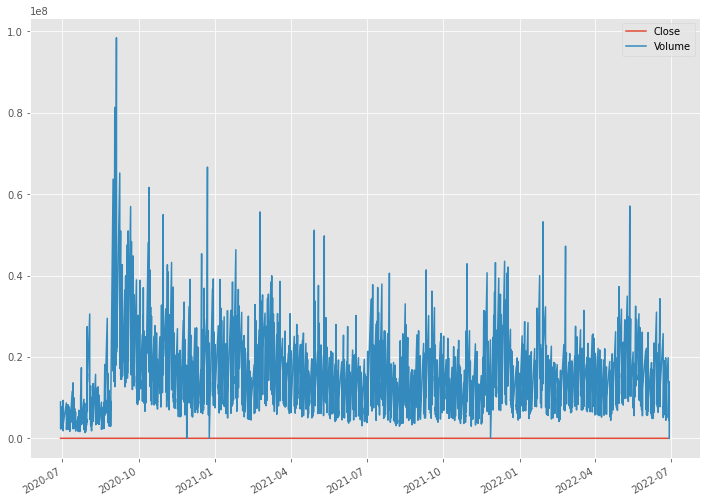

In [145]:
df3 = df.copy()
df3.drop(columns=["Open", "High", "Low"], inplace=True)
df3.plot()
df3.reset_index(inplace=True)
df3["Date"] = df3.index
df3.drop(columns=["index"], inplace=True)
df3.head()

In [146]:
# 学習データ
LAST_DAYS = 24 * 7

train = df3.iloc[:-1*LAST_DAYS]
y_train = train['Close']              #目的変数y
X_train = train.drop(columns=['Close']) #説明変数X
# テストデータ
test = df3.iloc[-1*LAST_DAYS:]  #テストデータ
y_test = test['Close']              #目的変数y
X_test = test.drop(columns=['Close']) #説明変数X
train.head()

,Close,Volume,Date
0,89.302498,8955346,0
1,89.917450,4733992,1
2,90.298576,4059912,2
3,90.043953,2958195,3
4,90.132500,2296096,4


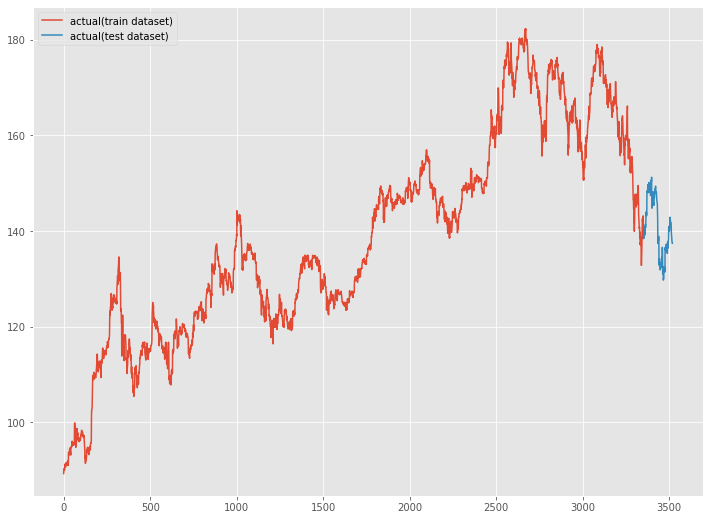

In [147]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(y_train.index, y_train.values, label="actual(train dataset)")
ax.plot(y_test.index, y_test.values, label="actual(test dataset)")
plt.legend()

In [148]:
regressor = xgb.XGBRegressor()
regressor.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)])

[0]	validation_0-rmse:98.04667	validation_1-rmse:97.82534
[1]	validation_0-rmse:68.78312	validation_1-rmse:66.60630
[2]	validation_0-rmse:48.30966	validation_1-rmse:46.57440
[3]	validation_0-rmse:33.97732	validation_1-rmse:33.84741
[4]	validation_0-rmse:23.93514	validation_1-rmse:23.60873
[5]	validation_0-rmse:16.91876	validation_1-rmse:17.27297
[6]	validation_0-rmse:11.99778	validation_1-rmse:13.64632
[7]	validation_0-rmse:8.55920	validation_1-rmse:10.06248
[8]	validation_0-rmse:6.18956	validation_1-rmse:8.37173
[9]	validation_0-rmse:4.51620	validation_1-rmse:7.11538
[10]	validation_0-rmse:3.37639	validation_1-rmse:7.03326
[11]	validation_0-rmse:2.59575	validation_1-rmse:6.63718
[12]	validation_0-rmse:2.09351	validation_1-rmse:6.41058
[13]	validation_0-rmse:1.75588	validation_1-rmse:6.27361
[14]	validation_0-rmse:1.54834	validation_1-rmse:6.15666
[15]	validation_0-rmse:1.41359	validation_1-rmse:6.13772
[16]	validation_0-rmse:1.33889	validation_1-rmse:6.11500
[17]	validation_0-rmse:1.2

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [149]:
# 特徴量重要度（Feature Importances）
df_importance = pd.DataFrame(zip(X_train.columns,
                                 regressor.feature_importances_),
                             columns=["Features","Importance"])
df_importance = df_importance.sort_values("Importance",
                                          ascending=False)
df_importance #確認

,Features,Importance
1,Date,0.998567
0,Volume,0.001433


<AxesSubplot:xlabel='Features'>

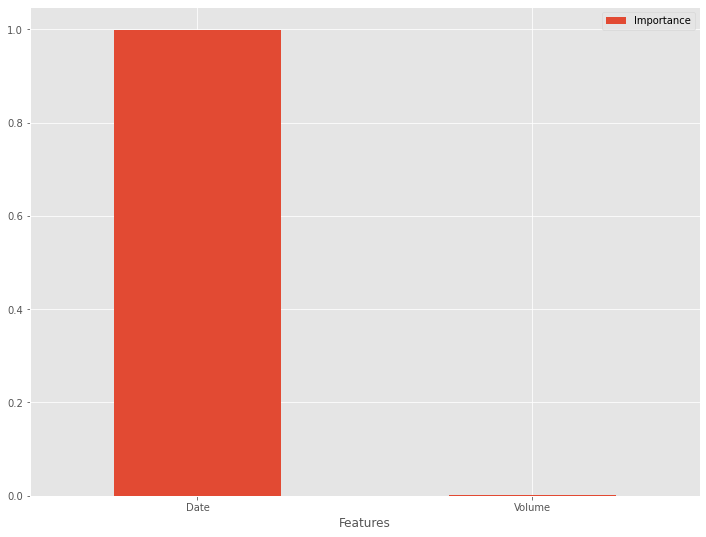

In [150]:
df_importance.plot.bar(x='Features',y='Importance', rot=0)

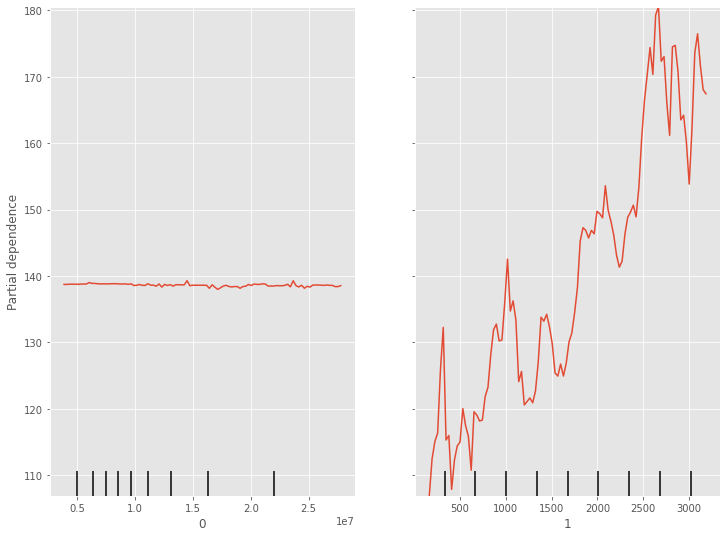

In [151]:
PartialDependenceDisplay.from_estimator(regressor, 
                                        X_train.values, 
                                        features=[0,1])

In [152]:
train_pred = regressor.predict(X_train.values)
test_pred = regressor.predict(X_test.values)
# 精度指標（テストデータ）
print('RMSE:')
print(np.sqrt(mean_squared_error(y_test, test_pred)))
print('MAE:')
print(mean_absolute_error(y_test, test_pred))
print('MAPE:')
print(mean_absolute_percentage_error(y_test, test_pred))

RMSE:
6.100881806939118
MAE:
5.3673051198323565
MAPE:
0.03827215239743381


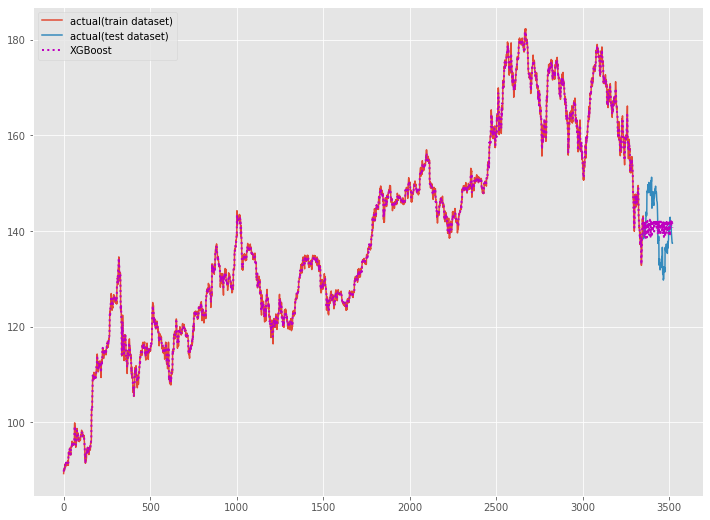

In [153]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(y_train.index, y_train.values, label="actual(train dataset)")
ax.plot(y_test.index, y_test.values, label="actual(test dataset)")
ax.plot(y_train.index, train_pred, linestyle="dotted", lw=2,color="m")
ax.plot(y_test.index, test_pred, label="XGBoost", linestyle="dotted", lw=2, color="m") 
plt.legend()

In [154]:
from sklearn import model_selection
import optuna

In [155]:
# XGBoostモデル
regressor = xgb.XGBRegressor()
# 目的関数の設定
def objective(trial):

    #ハイパーパラメータの探索の設定
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
    }
    regressor.set_params(**params)
    #CV（クロスバリデーション）の設定
    score = model_selection.cross_val_score(regressor,
                                            X_train,
                                            y_train,
                                            n_jobs=-1,
                                            cv=10,
                                            scoring = 'neg_mean_squared_error'
                                           )
    val = - score.mean()
    return val

In [156]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2022-06-28 23:12:23,845] A new study created in memory with name: no-name-53bee58c-3d56-4917-aab1-7817e93d9c93
[I 2022-06-28 23:12:24,303] Trial 0 finished with value: 72.67474632884685 and parameters: {'max_depth': 2, 'n_estimators': 256, 'learning_rate': 0.020430559879495984}. Best is trial 0 with value: 72.67474632884685.
[I 2022-06-28 23:12:25,886] Trial 1 finished with value: 19562.725135480265 and parameters: {'max_depth': 3, 'n_estimators': 651, 'learning_rate': 1.7793634586079083e-08}. Best is trial 0 with value: 72.67474632884685.
[I 2022-06-28 23:12:27,862] Trial 2 finished with value: 81.3701546902598 and parameters: {'max_depth': 6, 'n_estimators': 461, 'learning_rate': 0.03313522351093782}. Best is trial 0 with value: 72.67474632884685.
[I 2022-06-28 23:12:30,545] Trial 3 finished with value: 18032.797042503935 and parameters: {'max_depth': 8, 'n_estimators': 898, 'learning_rate': 4.5091828676572667e-05}. Best is trial 0 with value: 72.67474632884685.
[I 2022-06-28 23:1

In [157]:
print(f"The best parameters are : \n {study.best_params}")

The best parameters are : 
 {'max_depth': 2, 'n_estimators': 256, 'learning_rate': 0.020430559879495984}


In [158]:
# 最適パラメータでモデル学習
regressor = xgb.XGBRegressor(**study.best_params)
regressor.fit(X_train.values, y_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.020430559879495984, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=2, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=256, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [159]:
# 特徴量重要度（Feature Importances）
df_importance = pd.DataFrame(zip(X_train.columns,
                                 regressor.feature_importances_),
                             columns=["Features","Importance"])
df_importance = df_importance.sort_values("Importance",
                                          ascending=False)
df_importance #確認

,Features,Importance
1,Date,0.990956
0,Volume,0.009044


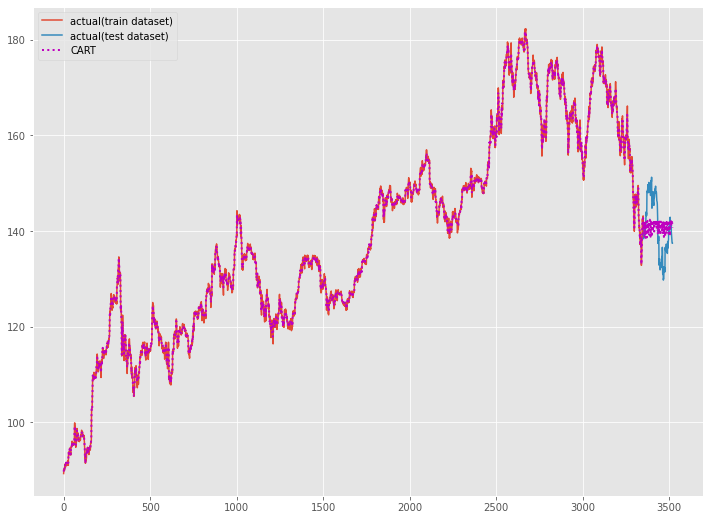

In [160]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(y_train.index, y_train.values, label="actual(train dataset)")
ax.plot(y_test.index, y_test.values, label="actual(test dataset)")
ax.plot(y_train.index, train_pred, linestyle="dotted", lw=2,color="m")
ax.plot(y_test.index, test_pred, label="CART", linestyle="dotted", lw=2, color="m") 
plt.legend()